# Лабораторная работа № 2 "Методы классификации данных"

## ФИО: Меженин Михаил Дмитриевич. Группа 17-АС

## Вариант 14(3 / 3, 4)

### Цель лабораторной работы – получение навыков работы с методами классификации.


   1. Изучить набор данных. Создать описание набора данных на русском языке. Описать признаки, используемые в наборе данных (включить полученные описания в отчёт).
   2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции;
   3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)
   4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию);
   5. Выполните замену категориальных признаков; выберите и обоснуйте способ замены;
   6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации);
   7. Заполните пропущенные значения в данных;
   8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию.
   9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.


In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn as skl
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import Perceptron
%matplotlib inline

In [80]:
zoo_data_df = pd.read_csv("zoo.csv")
class_data_df = pd.read_csv("class.csv")
zoo_data_df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


### 1. Изучить набор данных

**zoo.csv**

* animal_name - Имя животного
* hair - Есть ли шерсть
* feathers - Есть ли перья
* eggs - яйца (как тип размножения)
* milk - дает ли молоко
* airborne - умеет ли летать животное
* aquatic - живет ли в воде
* predator - животное хищник?
* toothed - есть ли зубы у животного
* backbone - есть ли позвоночник у животного
* breathes - дышит ли животное (воздухом)?
* venomous - ядовитое ли животное?
* fins - есть ли ребра?
* legs - сколько ног
* tail - есть ли хвост?
* domestic - домашнее ли животное
* catsize - ???
* class_type - тип класса

**class.csv**

* Class_Number (номер класса) Numeric (числовые). Целочисленные значения в диапазоне [1,7]
* Number_Of_Animal_Species_In_Class (количество видов животных в классе) Numeric (числовые)
* Class_Type character (тип класса) Фактическое описание типа класса
* Animal_Names character (название класса животных) Список животных, попадающих в категорию класса


### 2. Удалите дубликаты строк в наборе данных; приведите размер набора данных до и после данной операции.

In [81]:
print("Размер набора данных до удаления дубликатов: %d" % len(zoo_data_df))
zoo_data_df.drop_duplicates(keep='first', inplace = True)
print("После удаление дубликатов: %d" % len(zoo_data_df))

Размер набора данных до удаления дубликатов: 101
После удаление дубликатов: 101


### 3. Оцените сбалансированность данных по классам (постройте гистограмму). Используйте полученную информацию при выборе метрики оценки качества классификации (PR или ROC кривая)

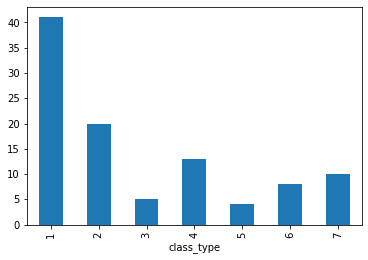

In [82]:
zoo_data_df.groupby(["class_type"])["class_type"].count().plot(kind='bar')

### 4. Выполните масштабирование количественных признаков; Постройте диаграммы BoxPlot для признаков до и после масштабирования. Выберите способ масштабирования (например, нормализацию или стандартизацию)

In [83]:
zoo_data_df.describe()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,0.425743,0.198020,0.584158,0.405941,0.237624,0.356436,0.554455,0.603960,0.821782,0.792079,0.079208,0.168317,2.841584,0.742574,0.128713,0.435644,2.831683
std,0.496921,0.400495,0.495325,0.493522,0.427750,0.481335,0.499505,0.491512,0.384605,0.407844,0.271410,0.376013,2.033385,0.439397,0.336552,0.498314,2.102709
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,0.000000,2.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,1.000000,0.000000,1.000000,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,1.000000,1.000000,1.000000,7.000000


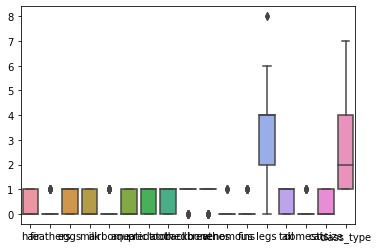

In [84]:
categorical_columns = [column for column in zoo_data_df.columns if zoo_data_df[column].dtype.name == 'object']
numerical_columns   = [column for column in zoo_data_df.columns if zoo_data_df[column].dtype.name != 'object']
sns.boxplot(data = zoo_data_df[numerical_columns])

**Способ масштабирования - нормализация** 

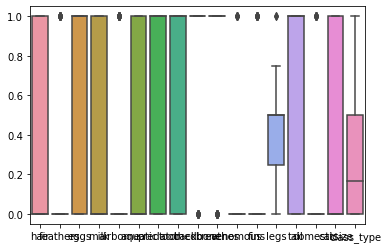

In [85]:
zoo_data_df[numerical_columns] = preprocessing.MinMaxScaler().fit_transform(zoo_data_df[numerical_columns].values.
                                                                            astype(float)) 
sns.boxplot(data = zoo_data_df[numerical_columns])

### 5. Выполните замену категориальных признаков; выберите и обоснуйте способ замены

Т.к категория "animal_name" единственная - сделаем для нее кодировку с помощью LabelEncoder

In [86]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(zoo_data_df.animal_name)
zoo_data_df["animal_name"] = le.transform(zoo_data_df.animal_name)
zoo_data_df

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.50,0.0,0.0,1.0,0.000000
1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.50,1.0,0.0,1.0,0.000000
2,2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.00,1.0,0.0,0.0,0.500000
3,3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.50,0.0,0.0,1.0,0.000000
4,4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.50,1.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,95,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.25,1.0,0.0,1.0,0.000000
97,96,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.75,0.0,0.0,0.0,0.833333
98,97,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.50,1.0,0.0,1.0,0.000000
99,98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,1.000000


### 6. Оцените корреляцию между признаков и удалите те признаки, которые коррелируют с наибольшим числом других (удалять признаки нужно только для линейных методов классификации)

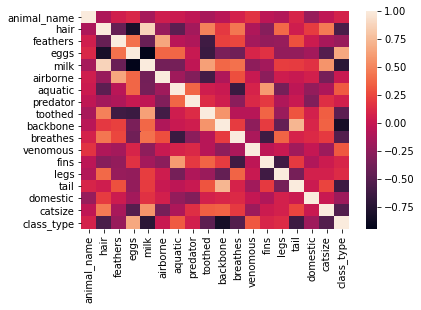

In [87]:
corr_matrix = zoo_data_df.corr()
sns.heatmap(corr_matrix);

### 7. Заполните пропущенные значения в данных

In [88]:
zoo_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   animal_name  101 non-null    int32  
 1   hair         101 non-null    float64
 2   feathers     101 non-null    float64
 3   eggs         101 non-null    float64
 4   milk         101 non-null    float64
 5   airborne     101 non-null    float64
 6   aquatic      101 non-null    float64
 7   predator     101 non-null    float64
 8   toothed      101 non-null    float64
 9   backbone     101 non-null    float64
 10  breathes     101 non-null    float64
 11  venomous     101 non-null    float64
 12  fins         101 non-null    float64
 13  legs         101 non-null    float64
 14  tail         101 non-null    float64
 15  domestic     101 non-null    float64
 16  catsize      101 non-null    float64
 17  class_type   101 non-null    float64
dtypes: float64(17), int32(1)
memory usage: 14.6 KB


Нет пропущенных значений

### 8. Решите поставленную задачу классификации в соответствии с заданием. При подборе параметров классификатора используйте метод GridSearchCV и перекрёстную проверку (изучите возможные для изменения параметры классификации). Определите схему построения многоклассового классификатора, используемую по умолчанию (опишите используемую схему кодирования, обоснуйте свой выбор). Постройте, если это возможно, многоклассовую классификацию на основе схем «один-против-всех» и «все-против-всех». Оцените точность классификации для каждой их схем. Постройте кривые PR и ROC (для каждого из классов должны быть построены отдельные кривые, а также кривые для микро и макроусреднения метрик качества). Для линейного классификатора используйте регуляризацию.

In [89]:
zoo_data_df.head()

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,0.0
1,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,0.0
2,2,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.5
3,3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,0.0
4,4,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.5,1.0,0.0,1.0,0.0


In [90]:
zoo_data_df.drop('animal_name', axis=1, inplace = True)
data_X, data_Y = zoo_data_df.drop('predator', axis=1).values, zoo_data_df['predator']
train_x, test_x, train_y, test_y = train_test_split(data_X, data_Y, test_size=0.3, random_state = 123)

print (train_x.shape)
print (test_x.shape)

(70, 16)
(31, 16)


**Логический классификатор (бинарное решающее дерево)**

In [91]:
dtc = DecisionTreeClassifier()

dtc_grid = GridSearchCV(dtc, {'max_depth': list(range(1, 5)), 'max_features': list(range(1, 5))})
dtc_grid.fit (train_x, train_y)
best_features = dtc_grid.best_estimator_.max_features
best_depth = dtc_grid.best_estimator_.max_depth
best_score = dtc_grid.best_score_

print('best score:', best_score, 
      ', features number:', best_features,
      ', depth:', best_depth)
dtc = DecisionTreeClassifier(max_depth=best_depth, max_features=best_features)
dtc.fit(train_x, train_y)
best_score = np.mean(test_y == dtc.predict(test_x))
print('test score:', best_score)

best score: 0.7142857142857142 , features number: 4 , depth: 2
test score: 0.6129032258064516


**Линейный классификатор**

In [92]:
ppn = Perceptron()

search = GridSearchCV(estimator=ppn, param_grid={
    'alpha': np.linspace(0, 1, 20)[1:],
    'max_iter': [x for x in range(1, 50)],
}, n_jobs=-1)
search.fit(train_x, train_y)
alpha = search.best_estimator_.alpha
max_iter = search.best_estimator_.max_iter
best = search.best_score_
print('best:', best, 'alpha:', alpha, 'max_iter:', max_iter)

ppn = Perceptron(alpha=alpha, max_iter=max_iter)
ppn.fit(train_x, train_y)
ppn_predict = ppn.predict(test_x)
print('Accuracy ppn: %.5f' % accuracy_score(test_y, ppn_predict))

best: 0.6714285714285715 alpha: 0.05263157894736842 max_iter: 10
Accuracy ppn: 0.64516


In [93]:
import warnings
warnings.simplefilter('ignore')

In [94]:
test_y_inversion = [1-y for y in test_y]

prob_dtc = dtc.predict_proba(test_x)

cppn = CalibratedClassifierCV(ppn, cv=10)
cppn.fit(train_x, train_y)
prob_ppn = cppn.predict_proba(test_x)


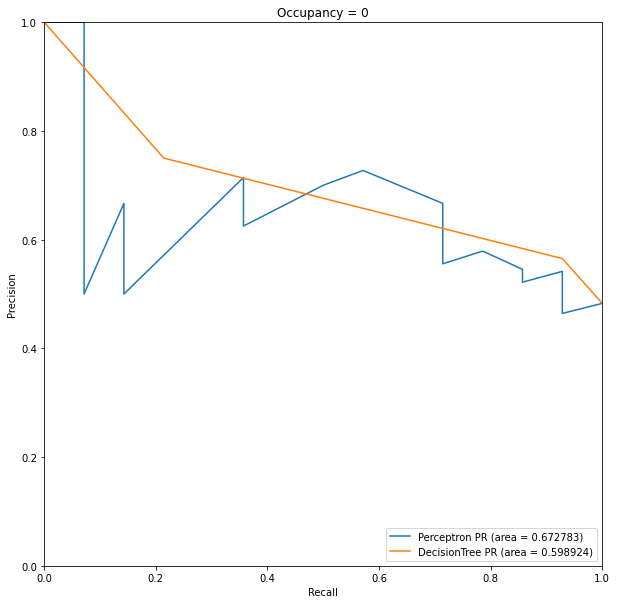

In [95]:
def PR(prob, occupancy, label, test):
    precision, recall, _ = precision_recall_curve(test, prob[:, occupancy])
    aps = average_precision_score(test, prob[:, occupancy])
    plt.plot(recall, precision, label='%s PR (area = %f)' % (label, aps))
plt.figure(figsize=(10,10))
PR(prob_ppn, 0, 'Perceptron', test_y_inversion)
PR(prob_dtc, 0, 'DecisionTree', test_y_inversion)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Occupancy = 0')
plt.legend(loc=4, fontsize='medium')
plt.show()

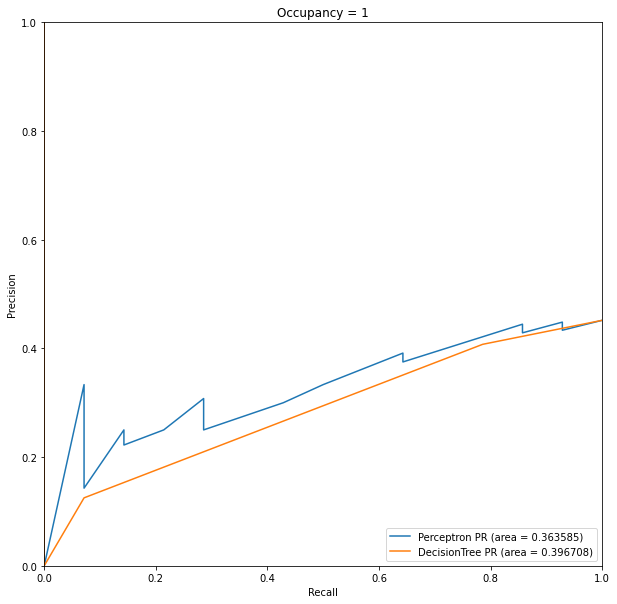

In [96]:
plt.figure(figsize=(10,10))
PR(prob_ppn, 1, 'Perceptron', test_y_inversion)
PR(prob_dtc, 1, 'DecisionTree', test_y_inversion)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Occupancy = 1')
plt.legend(loc=4, fontsize='medium')
plt.show()

**ROC**

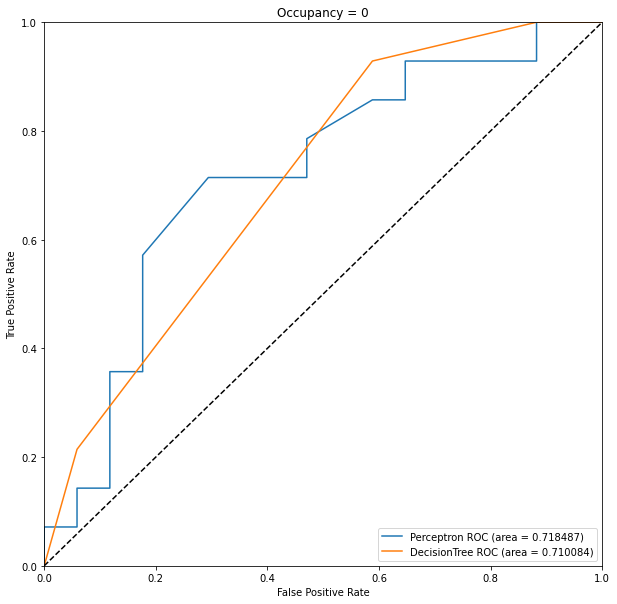

In [97]:
def ROC(prob, occupancy, label, test):
    tpr, fpr, _ = roc_curve(test, prob[:, occupancy])
    roc_auc  = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s ROC (area = %f)' % (label, roc_auc))

plt.figure(figsize=(10,10))

ROC(prob_ppn, 0, 'Perceptron', test_y)
ROC(prob_dtc, 0, 'DecisionTree', test_y)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 0')
plt.show()

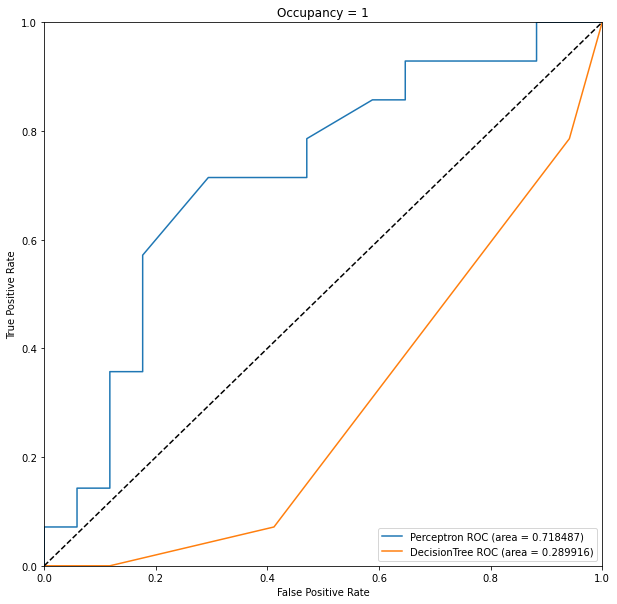

In [98]:
plt.figure(figsize=(10,10))

ROC(prob_ppn, 0, 'Perceptron', test_y)
ROC(prob_dtc, 1, 'DecisionTree', test_y)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4, fontsize='medium')
plt.title('Occupancy = 1')
plt.show()

### 9. Сравните кривые для классификаторов, указанных в задании, сделайте выводы.

Оптимальным будет логический классификатор